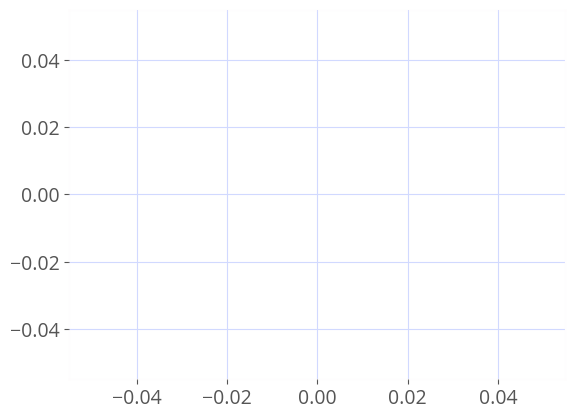

0-element Array{Any,1}

In [12]:
using DataFrames, CSV, PyPlot, PorousMaterials

PyPlot.matplotlib.font_manager.fontManager.addfont("OpenSans-Regular.ttf")
# PyPlot.matplotlib.font_manager.fontManager.addfont("Abel-Regular.ttf")
PyPlot.matplotlib.style.use("grandbudapest.mplstyle")

plot()

# methane adsorption HKUST-1 and MOF-5
read in adsorption data, covert uptake to mmol/g

In [13]:
mofs = ["HKUST-1", "MOF-5"]
df = Dict{String, DataFrame}()
for mof in mofs
    df[mof] = CSV.read("ch4_" * mof * "_25C.csv", comment="#")
    df[mof][!, :m_mmol_g] = df[mof][:, Symbol("N(cm3/g)")] / 22.4
end
first(df[mofs[1]], 3)

,P(bar),N(cm3/g),m_mmol_g
,Float64,Float64,Float64
1,0.68,15.52,0.692857
2,1.72,34.43,1.53705
3,3.55,62.79,2.80313


fit Langmuir model

In [14]:
params = Dict(mof => fit_adsorption_isotherm(df[mof], Symbol("P(bar)"), :m_mmol_g, :langmuir) for mof in mofs)

Dict{String,Dict{String,Float64}} with 2 entries:
  "MOF-5"   => Dict("M"=>32.2469,"K"=>0.0139923,"MSE"=>0.0322526)
  "HKUST-1" => Dict("M"=>16.6781,"K"=>0.0600375,"MSE"=>0.00464618)

In [15]:
m(p::Float64, mof::String) = params[mof]["M"] * params[mof]["K"] * p ./ (1 .+ params[mof]["K"] * p)
g(m::Float64, mof::String) = 1 / params[mof]["K"] * m / (params[mof]["M"] - m) # inverse

g (generic function with 1 method)

In [16]:
mof_to_color = Dict("MOF-5" => "C0", "HKUST-1" => "C1")

Dict{String,String} with 2 entries:
  "MOF-5"   => "C0"
  "HKUST-1" => "C1"

plot data with Langmuir fit

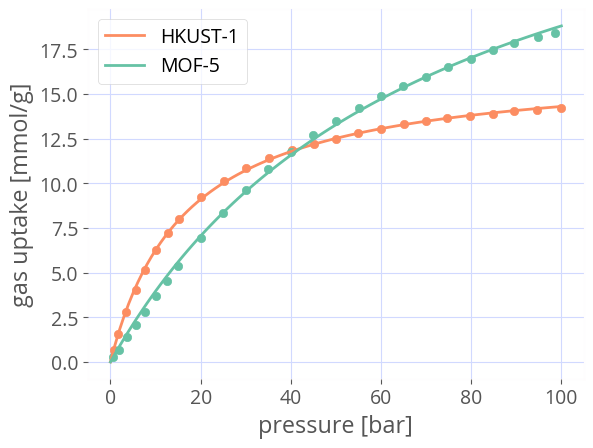

PyObject Text(34.000000000000014, 0.5, 'gas uptake [mmol/g]')

In [17]:
figure()
p = range(0.0, 100.0, length=100)
for mof in mofs
    scatter(df[mof][:, Symbol("P(bar)")], df[mof][:, :m_mmol_g], color=mof_to_color[mof])
    plot(p, m.(p, mof), label=mof, color=mof_to_color[mof])
end
legend()
xlabel("pressure [bar]")
ylabel("gas uptake [mmol/g]")

# illustrate $\delta m$

Rachel: put $\kappa(P)$ and $\kappa(m)$ for inverse problem here.

In [18]:
δm = 1.0
δ_color = "C4"

"C4"

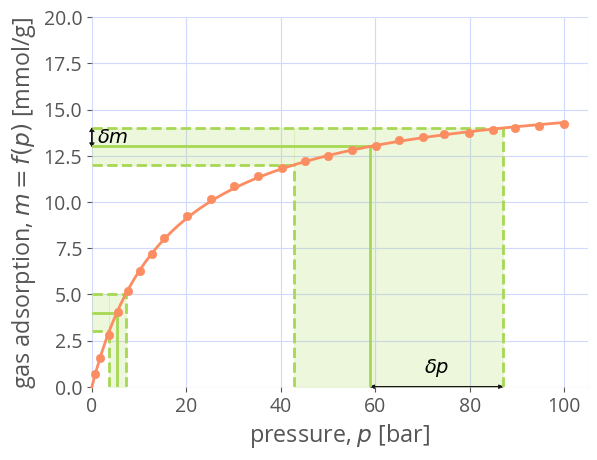

PyObject Text(38.000000000000014, 0.5, 'gas adsorption, $m=f(p)$ [mmol/g]')

In [19]:
ms = [4.0, 13.0]

figure()
p = range(0.0, 100.0, length=100)
mof = "HKUST-1"
scatter(df[mof][:, Symbol("P(bar)")], df[mof][:, :m_mmol_g], zorder=1000, 
    clip_on=false, color=mof_to_color[mof])
plot(p, params[mof]["M"] * params[mof]["K"] * p ./ (1 .+ params[mof]["K"] * p), 
    label=mof, zorder=1000, clip_on=false, color=mof_to_color[mof])
for (i, m) in enumerate(ms)
    p = g(m, mof)
    plot([p, p], [0, m], color=δ_color)
    plot([0, p], [m, m], color=δ_color)
    m_low = m - δm
    m_high = m + δm
    p_low = g(m_low, mof)
    p_high = g(m_high, mof)
    plot([p_low, p_low], [0, m_low], linestyle="--", color=δ_color)
    plot([0, p_low], [m_low, m_low], linestyle="--", color=δ_color)
    plot([p_high, p_high], [0, m_high], linestyle="--", color=δ_color)
    plot([0, p_high], [m_high, m_high], linestyle="--", color=δ_color)
    
    ps = range(p_low, p_high, length=200)
    fill_between(ps, [m_high for _ = 1:length(ps)], alpha=0.2, color=δ_color)
    fill_between([0.0, p_low], [m_low, m_low], [m_high, m_high], alpha=0.2, color=δ_color)
    if i == 2
        arrow(0.0, m, 0.0, δm, length_includes_head=true,
          head_width=1, head_length=0.2, clip_on=false, color="k")
        arrow(0.0, m+δm, 0.0, -δm, length_includes_head=true,
          head_width=1, head_length=0.2, clip_on=false, color="k")
        text(1.0, m + δm / 2, L"$\delta m$", verticalalignment="center")
        
        arrow(p, 0.0, p_high-p, 0.0, length_includes_head=true,
          head_width=0.2, head_length=1, clip_on=false, color="k")
        arrow(p_high, 0.0, p-p_high, 0.0, length_includes_head=true,
          head_width=0.2, head_length=1, clip_on=false, color="k")
        text(p + (p_high-p)/2, 0.75, L"$\delta p$", horizontalalignment="center")
    end
end

xlim(xmin=0.0)
ylim([0.0, 20.0])
xlabel(L"pressure, $p$ [bar]")
ylabel(L"gas adsorption, $m=f(p)$ [mmol/g]")

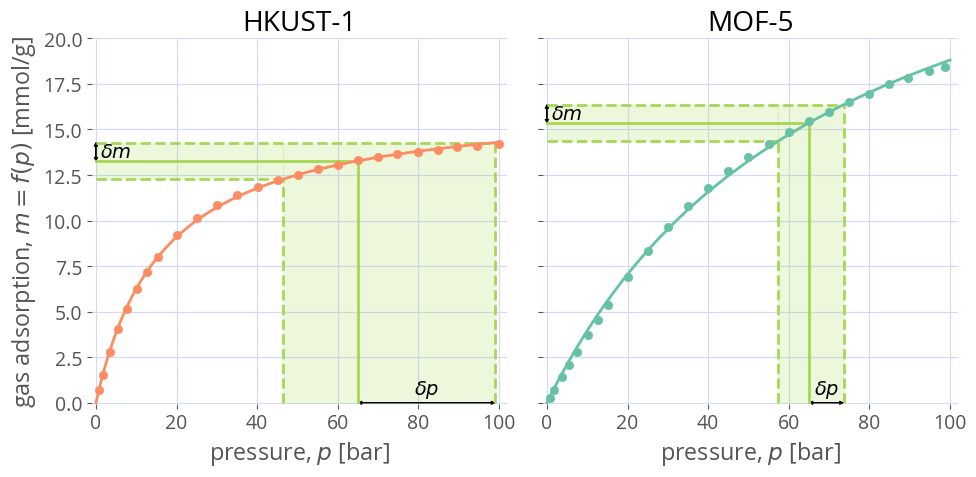

In [20]:
fig, axs = subplots(1, 2, figsize=(10, 5), sharey=true)
p = range(0.0, 100.0, length=100)
p̄ = 65.0
for (i, mof) in enumerate(mofs)    
    axs[i].scatter(df[mof][:, Symbol("P(bar)")], df[mof][:, :m_mmol_g], 
        color=mof_to_color[mof], zorder=2003)
    axs[i].plot(p, m.(p, mof), color=mof_to_color[mof], zorder=1000)
    axs[i].set_title(mof)
    
    m̄ = m(p̄, mof)
    axs[i].plot([p̄, p̄], [0, m̄], color=δ_color)
    axs[i].plot([0, p̄], [m̄, m̄], color=δ_color)
    
    m_high = m̄ + δm
    p_high = g(m_high, mof)
    m_low = m̄ - δm
    p_low = g(m_low, mof)
    axs[i].plot([p_low, p_low], [0, m_low], linestyle="--", color=δ_color)
    axs[i].plot([0, p_low], [m_low, m_low], linestyle="--", color=δ_color)
    axs[i].plot([p_high, p_high], [0, m_high], linestyle="--", color=δ_color)
    axs[i].plot([0, p_high], [m_high, m_high], linestyle="--", color=δ_color)
    
    axs[i].set_xlim([-1, 102])
    axs[i].set_ylim([-0.05, 20.0])
    
    ps = range(p_low, p_high, length=200)
    axs[i].fill_between(ps, [m_high for _ = 1:length(ps)], alpha=0.2, color=δ_color)
    axs[i].fill_between([0.0, p_low], [m_low, m_low], [m_high, m_high], alpha=0.2, color=δ_color)
    
    axs[i].arrow(0.0, m̄, 0.0, δm, length_includes_head=true,
      head_width=1, head_length=0.2, clip_on=false, color="k")
    axs[i].arrow(0.0, m̄+δm, 0.0, -δm, length_includes_head=true,
      head_width=1, head_length=0.2, clip_on=false, color="k")
    axs[i].text(1.0, m̄ + δm / 2, L"$\delta m$", verticalalignment="center")

    axs[i].arrow(p̄, 0.0, p_high-p̄, 0.0, length_includes_head=true,
      head_width=0.2, head_length=1, clip_on=false, color="k")
    axs[i].arrow(p_high, 0.0, p̄-p_high, 0.0, length_includes_head=true,
      head_width=0.2, head_length=1, clip_on=false, color="k")
    axs[i].text(p̄ + (p_high-p̄)/2, 0.5, L"$\delta p$", horizontalalignment="center")
    axs[i].set_xlabel(L"pressure, $p$ [bar]")
end
axs[1].set_ylabel(L"gas adsorption, $m=f(p)$ [mmol/g]")
tight_layout()

# $\kappa(p)$

In [21]:
#absolute error in predicted gas comp. over absolute error in data
κ_of_m(m::Float64) = params[mof]["M"] / (params[mof]["K"] * (params[mof]["M"] - m)^2)  # inverse kappa with respect to m
κ_of_p(p::Float64) = (1 + params[mof]["K"] * p)^2 / (params[mof]["K"] * params[mof]["M"]) # inverse kappa with respect to p   

κ_of_p (generic function with 1 method)

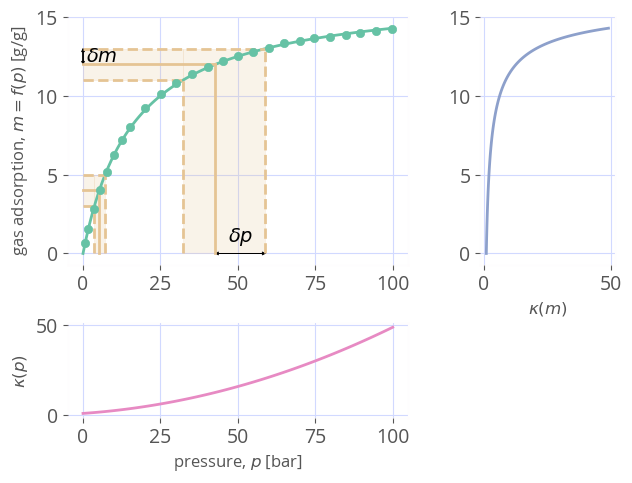

In [80]:
p = range(0.0, 100.0, length=100)

mof = "HKUST-1"
#mof = "MOF-5"

fig = figure()
ax1 = subplot2grid((3, 3), (0, 0), colspan=2, rowspan=2)
ax2 = subplot2grid((3, 3), (0, 2), colspan=1, rowspan=2)
ax3 = subplot2grid((3, 3), (2, 0), colspan=2, rowspan=1)
tight_layout()

ax1.plot(p, m.(p, mof))
ax1.scatter(df[mof][:, Symbol("P(bar)")], df[mof][:, :m_mmol_g], zorder=1000, 
    clip_on=false)
ax2.plot(κ_of_m.(m.(p, mof)), m.(p, mof), color="C2")
ax3.plot(p, κ_of_p.(p), color="C3")

ax1.set_ylabel(L"gas adsorption, $m=f(p)$ [g/g]", fontsize=12)
ax3.set_xlabel(L"pressure, $p$ [bar]", fontsize=12)
ax3.set_ylabel(L"$κ(p)$", fontsize=12)
ax2.set_xlabel(L"$κ(m)$", fontsize=12)


δ_color = "C6"
ms = [4.0, 12.0]
for (i, m) in enumerate(ms)
    p = g(m, mof)
    ax1.plot([p, p], [0, m], color=δ_color)
    ax1.plot([0, p], [m, m], color=δ_color)
    m_low = m - δm
    m_high = m + δm
    p_low = g(m_low, mof)
    p_high = g(m_high, mof)
    ax1.plot([p_low, p_low], [0, m_low], linestyle="--", color=δ_color)
    ax1.plot([0, p_low], [m_low, m_low], linestyle="--", color=δ_color)
    ax1.plot([p_high, p_high], [0, m_high], linestyle="--", color=δ_color)
    ax1.plot([0, p_high], [m_high, m_high], linestyle="--", color=δ_color)
    
    ps = range(p_low, p_high, length=200)
    ax1.fill_between(ps, [m_high for _ = 1:length(ps)], alpha=0.2, color=δ_color)
    ax1.fill_between([0.0, p_low], [m_low, m_low], [m_high, m_high], alpha=0.2, color=δ_color)
    if i == 2
        ax1.arrow(0.0, m, 0.0, δm, length_includes_head=true,
          head_width=1, head_length=0.2, clip_on=false, color="k")
        ax1.arrow(0.0, m+δm, 0.0, -δm, length_includes_head=true,
          head_width=1, head_length=0.2, clip_on=false, color="k")
        ax1.text(1.0, m + δm / 2, L"$\delta m$", verticalalignment="center")
        
        ax1.arrow(p, 0.0, p_high-p, 0.0, length_includes_head=true,
          head_width=0.2, head_length=1, clip_on=false, color="k")
        ax1.arrow(p_high, 0.0, p-p_high, 0.0, length_includes_head=true,
          head_width=0.2, head_length=1, clip_on=false, color="k")
        ax1.text(p + (p_high-p)/2, 0.75, L"$\delta p$", horizontalalignment="center")
    end
end